# 🏠 Capstone Project Final (24.1) - Data Ingestion

- Sample Raw Data Ingestion Script for Capstone 24.1
- Author: Siddarth R Mannem

## Data Ingestion (00_data_ingestion.ipynb)

---

### **1. Purpose**

This notebook constructs the **foundational dataset** for the *Buy vs. Rent Decision Model* at **ZIP code level**.  
It aggregates housing market indicators, financial rates, and cost parameters into a single, time-aligned dataset —  
`master_housing_dataset_zip.csv` — which serves as the analytical backbone for downstream notebooks in this project.

**Key objectives:**
- Load and preprocess Zillow data (Home Values and Rent Indices) at ZIP level.  
- Join ZIP-level housing metrics with **state-level** financial attributes:  
  - Mortgage rates (FRED “MORTGAGE30US”)  
  - Property tax rates (3-year averages)  
  - Insurance and maintenance cost percentages  
  - State-level tax share and economic growth indicators  
- Produce tidy, monthly datasets compatible with ML modeling and forecasting pipelines.
- Fetch publicly available datasets (Zillow, FRED) for Buy vs Rent project

---

### **2. Changes from Previous Assignment (20.1)**

The earlier *Capstone Assignment 20.1* analyzed **state-level data only**.  
This upgraded version (Capstone Final 24.1) expands the pipeline to **ZIP-code granularity**, offering finer spatial detail.

**Major enhancements:**
- **ZIP-level Zillow datasets integrated:**
  - `Zipcode_zhvi_sa_month.csv` → Zillow Home Value Index (ZHVI)  
  - `Zipcode_zori_sm_month.csv` → Zillow Observed Rent Index (ZORI)  
- **New preprocessing functions** to reshape Zillow’s wide monthly data into long “tidy” format.
- **Expanded schema:**  
  - Columns now include `zip`, `City`, `Metro`, `county_name`, in addition to `state`.  
  - `median_price` and `median_rent` reflect ZIP-level medians.
- **Updated joins:** all merges (FRED, tax, cost, growth) are now aligned by `zip` + `state` + `date`.
- **Extended date coverage:** 2015 → 2025 Zillow updates.
- **New derived indicators:**  
  - `rent_to_price_ratio` and `price_to_rent_years`  
  - `total_annual_ownership_cost_pct`  
  - `median_price_growth` and `median_rent_growth` (12-month rolling % changes)
- **Improved normalization logic:** standardized state codes and month-start date alignment.

---

### **3. Goal**

To generate a **comprehensive, analysis-ready dataset** that captures monthly housing and rental dynamics across all U.S. ZIP codes.  
This dataset will be used for:
- Predictive modeling to determine **Buy vs. Rent recommendations**
- **2-year forecasting** of price and rent trends
- **Scenario and sensitivity analysis** on mortgage rates, taxes, and costs
- Powering a future **Streamlit / FastAPI** interface for ZIP-level affordability insights

---

### **Output Summary**

| Output File                            | Description |
|----------------------------------------|-------------|
| `data2/zillow_zip_prices.csv`          | Cleaned Zillow Home Value Index (ZHVI) by ZIP |
| `data2/zillow_zip_rents.csv`           | Cleaned Zillow Rent Index (ZORI) by ZIP |
| `data2/master_housing_dataset_zip.csv` | Final unified dataset for modeling (2015–2025) |

---


In [2]:
# ----------------------------------------------------
# SECTION 1: Setup & Imports
# ----------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import requests
from io import StringIO
import time
from pathlib import Path

# Create data folder in Colab environment
import os
if not os.path.exists('data'):
  os.makedirs('data')

In [3]:
from google.colab import drive
drive.mount('/content/drive')
capstone_data_base_path = '/content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/'
capstone_data_base_path_out_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/'

capstone_figures_base_path = '/content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/figures/'


# If you are running inside the repo, put the two Zillow files under data/
# For your local run in Colab, either upload or mount Drive and set these paths.
# Using your uploaded file locations here for convenience:
zori_fp = Path("/mnt/data/Zipcode_zori_sm_month.csv")   # ZORI ZIP monthly wide
zhvi_fp = Path("/mnt/data/Zipcode_zhvi_sa_month.csv")   # ZHVI ZIP monthly wide

# Outputs (use your repo's data/ folder when running in Colab/Git):
out_dir = Path(capstone_data_base_path) # + '/out/')
out_dir.mkdir(parents=True, exist_ok=True)


Mounted at /content/drive


In [6]:
State_zhvi_sa_month_csv = capstone_data_base_path + 'State_zhvi_sa_month.csv'  # Zillow Home Value Index (ZHVI) by state and per each month
State_zhvi_sa_month_df = pd.read_csv(State_zhvi_sa_month_csv)
print(State_zhvi_sa_month_df.iloc[:2, :6])

zipcode_zhvi_sa_month_csv = capstone_data_base_path + 'Zipcode_zhvi_sa_month.csv' # Zillow Home Value Index (ZHVI) by zipcode and per each month
zipcode_zhvi_sa_month_df = pd.read_csv(zipcode_zhvi_sa_month_csv)
print(zipcode_zhvi_sa_month_df.iloc[:2, :9])

   RegionID  SizeRank  RegionName RegionType  StateName     2000-01-31
0         9         0  California      state        NaN  188662.543010
1        54         1       Texas      state        NaN  113452.441026
   RegionID  SizeRank  RegionName RegionType StateName State      City  \
0     91982         1       77494        zip        TX    TX      Katy   
1     61148         2        8701        zip        NJ    NJ  Lakewood   

                                   Metro        CountyName  
0   Houston-The Woodlands-Sugar Land, TX  Fort Bend County  
1  New York-Newark-Jersey City, NY-NJ-PA      Ocean County  


In [7]:
metro_zori_sm_month_csv = capstone_data_base_path + 'State_zori_sm_month.csv'  # Zillow Observed Rent Index (ZORI) by state and per each month
metro_zori_sm_month_df = pd.read_csv(metro_zori_sm_month_csv)
print(metro_zori_sm_month_df.iloc[:2, :6])

zipcode_zori_sm_month_csv = capstone_data_base_path + 'Zipcode_zori_sm_month.csv'  # Zillow Observed Rent Index (ZORI) by zipcode and per each month
zipcode_zori_sm_month_df = pd.read_csv(zipcode_zori_sm_month_csv)
# drop column State
# zipcode_zori_sm_month_df = zipcode_zori_sm_month_df.drop(columns=['State'])
print(zipcode_zori_sm_month_df.iloc[:2, :9])


   RegionID  SizeRank     RegionName RegionType StateName   2015-01-31
0    102001         0  United States    country       NaN  1194.531316
1    394913         1   New York, NY        msa        NY  2351.780210
   RegionID  SizeRank  RegionName RegionType StateName State  City  \
0     91982         1       77494        zip        TX    TX  Katy   
1     91940         3       77449        zip        TX    TX  Katy   

                                  Metro        CountyName  
0  Houston-The Woodlands-Sugar Land, TX  Fort Bend County  
1  Houston-The Woodlands-Sugar Land, TX     Harris County  


In [5]:
# ----------------------------------------------------
# SECTION 2: Helper Functions
# ----------------------------------------------------
def fetch_fred_series(series_id, start_date=None, end_date=None):
    """Fetch a FRED time series as CSV and return a DataFrame."""
    base = "https://fred.stlouisfed.org/graph/fredgraph.csv"
    params = {'id': series_id}
    if start_date:
        params['cosd'] = start_date
    if end_date:
        params['coed'] = end_date
    resp = requests.get(base, params=params)
    resp.raise_for_status()
    df = pd.read_csv(StringIO(resp.text))
    print("Columns after reading CSV:", df.columns) # Debugging line
    # Check if 'DATE' column exists before renaming
    if 'DATE' in df.columns:
        df = df.rename(columns={'DATE': 'date'})
    elif 'observation_date' in df.columns: # Check for 'observation_date'
        df = df.rename(columns={'observation_date': 'date'})
    df['date'] = pd.to_datetime(df['date']) # Now 'date' column is guaranteed to exist
    df = df.sort_values('date')
    return df

def fetch_zillow_csv(csv_file_name, value_col_name):
    """Fetch Zillow CSV (ZHVI or ZORI) and reshape to long format."""
    # resp = requests.get(csv_url)
    # resp.raise_for_status()
    # df = pd.read_csv(StringIO(resp.text))

    # So read data from csv_file_name and assign it to df
    df = pd.read_csv(csv_file_name)
    # print first 2 rows and first 10 columns
    print("*** print first 5 rows and first 10 columns ***")
    print(df.iloc[:2, :10])
    # print last 2 rows and last 10 columns
    print("\n*** print last 5 rows and last 10 columns ***")
    print(df.iloc[-2:, :10])
    # Identify if monthly columns are present
    date_cols = [c for c in df.columns if c[:4].isdigit()]
    df_long = df.melt(id_vars=['RegionName'], value_vars=date_cols, var_name='date', value_name=value_col_name)
    df_long['date'] = pd.to_datetime(df_long['date']) # 'date' column is guaranteed to exist after melt
    df_long.rename(columns={'RegionName': 'state'}, inplace=True)
    return df_long

def melt_zillow_zip_wide_to_long(df: pd.DataFrame, value_name: str = "median_price") -> pd.DataFrame:
    """
    Convert Zillow ZIP-wide monthly ZORI table to long format:
      -> columns: zip, date, State, City, Metro, county_name, median_rent
    Keeps only RegionType=='zip'.  Trims header spaces.  Detects YYYY-MM-DD date columns.
    """
    # 🧹 Trim stray spaces (e.g., 'StateName ')
    df.columns = df.columns.str.strip()

    # Meta columns typically present in Zillow CSVs
    meta_cols = ["RegionID","RegionName","RegionType","State","City","Metro","CountyName","SizeRank"]
    meta_cols = [c for c in meta_cols if c in df.columns]

    # Detect date columns (strict YYYY-MM-DD)
    date_cols = [c for c in df.columns if c not in meta_cols]
    date_cols_clean = [c for c in date_cols if re.match(r"^\d{4}-\d{2}-\d{2}$", str(c))]
    if len(date_cols_clean) >= 6:
        date_cols = date_cols_clean # use the cleaner set if it looks good

    # Wide → long
    long_df = df.melt(id_vars=meta_cols, value_vars=date_cols, var_name="date", value_name=value_name)

    # Keep only ZIP rows
    if "RegionType" in long_df.columns:
        long_df = long_df[long_df["RegionType"].str.lower() == "zip"]

    # Normalize column names
    long_df = long_df.rename(columns={
        "RegionName": "zip",
        "CountyName": "county_name"
    })
    long_df["zip"] = long_df["zip"].astype(str).str.zfill(5)

    # Drop StateName to avoid duplicates; keep State (2-letter)
    keep_cols = ["zip","date","State","City","Metro","county_name", value_name]
    keep_cols = [c for c in keep_cols if c in long_df.columns]
    long_df = long_df[keep_cols].sort_values(["zip","date"]).reset_index(drop=True)

    return long_df

def melt_zillow_zip_wide_to_long_rent(df: pd.DataFrame, value_name: str = "median_rent") -> pd.DataFrame:
    """
    Convert Zillow ZIP-wide monthly ZORI table to long format:
      -> columns: zip, date, State, City, Metro, county_name, median_rent
    Keeps only RegionType=='zip'.  Trims header spaces.  Detects YYYY-MM-DD date columns.
    """
    # 🧹 Trim stray spaces (e.g., 'StateName ')
    df.columns = df.columns.str.strip()

    # Meta columns typically present in Zillow CSVs
    meta_cols = ["RegionID","RegionName","RegionType","State","City","Metro","CountyName","SizeRank","StateName"]
    meta_cols = [c for c in meta_cols if c in df.columns]

    # Detect date columns (strict YYYY-MM-DD)
    date_cols = [c for c in df.columns if c not in meta_cols]
    date_cols_clean = [c for c in date_cols if re.match(r"^\d{4}-\d{2}-\d{2}$", str(c))]
    if len(date_cols_clean) >= 6:
        date_cols = date_cols_clean

    # Wide → long
    long_df = df.melt(id_vars=meta_cols, value_vars=date_cols, var_name="date", value_name=value_name)
    long_df["date"] = pd.to_datetime(long_df["date"], errors="coerce")

    # Keep only ZIP rows
    if "RegionType" in long_df.columns:
        long_df = long_df[long_df["RegionType"].str.lower() == "zip"]

    # Normalize column names
    long_df = long_df.rename(columns={
        "RegionName": "zip",
        "CountyName": "county_name"
    })
    long_df["zip"] = long_df["zip"].astype(str).str.zfill(5)

    # Drop StateName to avoid duplicates; keep State (2-letter)
    keep_cols = ["zip","date","State","City","Metro","county_name", value_name]
    keep_cols = [c for c in keep_cols if c in long_df.columns]
    long_df = long_df[keep_cols].sort_values(["zip","date"]).reset_index(drop=True)
    return long_df

In [6]:

# ----------------------------------------------------
# SECTION 3: Fetch FRED Mortgage Rate
# ----------------------------------------------------
fred_series = 'MORTGAGE30US'  # 30-Year Fixed Rate Mortgage Average
fred_df = fetch_fred_series(fred_series, start_date='2000-01-01')
# print head()
print(fred_df.head())
print('capstone_data_base_path_out_dir: ' + capstone_data_base_path_out_dir)
# save to csv
fred_df.to_csv(capstone_data_base_path_out_dir + 'fred_mortgage_rate.csv', index=False)
fred_df.to_csv('data/fred_mortgage_rate.csv', index=False)
print('✅ Saved FRED mortgage rate to data/fred_mortgage_rate.csv')


Columns after reading CSV: Index(['observation_date', 'MORTGAGE30US'], dtype='object')
        date  MORTGAGE30US
0 2000-01-07          8.15
1 2000-01-14          8.18
2 2000-01-21          8.26
3 2000-01-28          8.25
4 2000-02-04          8.25
capstone_data_base_path_out_dir: /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/
✅ Saved FRED mortgage rate to data/fred_mortgage_rate.csv


In [7]:
# ----------------------------------------------------
# SECTION 4: Fetch Zillow ZHVI (Home Prices)
# ----------------------------------------------------
# Note: You must manually find Zillow CSV URL for state-level home values.
# Example placeholder URL below (update from Zillow Research page)
zillow_price_url = 'https://files.zillowstatic.com/research/public_csvs/zhvi/State_Zhvi_AllHomes.csv'


try:
    # 1️⃣ Read the Zillow ZIP-level file
    zhvi_zip_raw = pd.read_csv(zipcode_zhvi_sa_month_csv, low_memory=False)

    # 2️⃣ Convert wide → long
    zhvi_df = melt_zillow_zip_wide_to_long(zhvi_zip_raw, value_name="median_price")

    # 3️⃣ Drop missing and round to integer
    zhvi_df = zhvi_df.dropna(subset=["median_price"])
    zhvi_df["median_price"] = zhvi_df["median_price"].round(0).astype(int)

    print("\n*** ZIP-level ZHVI (long) preview ***")
    display(zhvi_df.head())

    # 4️⃣ Save outputs (to repo data folder + Drive mirror)
    out_local = Path("data/zillow_zip_prices.csv")
    zhvi_df.to_csv(out_local, index=False)
    zhvi_df.to_csv(capstone_data_base_path + "zillow_zip_prices.csv", index=False)

    print(f"\n✅ Saved Zillow ZIP home prices to {out_local}")
    print(f"✅ Also saved to {capstone_data_base_path + 'zillow_zip_prices.csv'}")

except Exception as e:
    print("\n⚠️ Could not process Zillow ZIP-level prices. Please verify file path and format.")
    print(f"Exception: {e}")




*** ZIP-level ZHVI (long) preview ***


,zip,date,State,City,Metro,county_name,median_price
0,01001,2000-01-31,MA,Agawam,"Springfield, MA",Hampden County,121926
1,01001,2000-02-29,MA,Agawam,"Springfield, MA",Hampden County,121880
2,01001,2000-03-31,MA,Agawam,"Springfield, MA",Hampden County,122027
3,01001,2000-04-30,MA,Agawam,"Springfield, MA",Hampden County,122359
4,01001,2000-05-31,MA,Agawam,"Springfield, MA",Hampden County,123219



✅ Saved Zillow ZIP home prices to data/zillow_zip_prices.csv
✅ Also saved to /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/zillow_zip_prices.csv


In [8]:

# ----------------------------------------------------
# SECTION 5: Fetch Zillow Rent Index (ZORI)
# ----------------------------------------------------
zillow_rent_url = 'https://files.zillowstatic.com/research/public_csvs/zori/State_ZORI_AllHomesPlusMultifamily.csv'

try:
    # 1️⃣ Read the Zillow ZIP-level ZORI (wide monthly)
    zori_zip_raw = pd.read_csv(zipcode_zori_sm_month_csv, low_memory=False)

    # 2️⃣ Wide → long
    rent_df = melt_zillow_zip_wide_to_long_rent(zori_zip_raw, value_name="median_rent")

    # 3️⃣ Drop missing and round to integer
    rent_df = rent_df.dropna(subset=["median_rent"])
    rent_df["median_rent"] = rent_df["median_rent"].round(0).astype(int)

    print("\n*** ZIP-level ZORI (long) preview ***")
    display(rent_df.head())

    # 4️⃣ Save outputs (repo data folder + new /out/ mirror)
    out_local = Path("data/zillow_zip_rents.csv")
    rent_df.to_csv(out_local, index=False)
    rent_df.to_csv(capstone_data_base_path_out_dir + "zillow_zip_rents.csv", index=False)

    print(f"\n✅ Saved Zillow ZIP rents to {out_local}")
    print(f"✅ Also saved to {capstone_data_base_path_out_dir + 'zillow_zip_rents.csv'}")

except Exception as e:
    print("\n⚠️ Could not process Zillow ZIP-level rents. Please verify file path and format.")
    print(f"Exception: {e}")


# Convert Metros to State
# rents = pd.read_csv(capstone_data_base_path + "zillow_metro_state_rents.csv")

# # Drop national aggregate row
# rents = rents[rents['state'] != 'United States'].copy()

# # Extract the state abbreviation (e.g., 'Los Angeles, CA' → 'CA')
# rents['state_code'] = rents['state'].str.extract(r',\s*([A-Z]{2})')

# # Drop rows where state_code couldn’t be extracted (e.g., malformed names)
# rents = rents.dropna(subset=['state_code'])

# # Keep only relevant columns
# rents = rents[['state_code', 'date', 'median_rent']]

# # Rename to match other datasets
# rents.rename(columns={'state_code':'state'}, inplace=True)

# # Convert to datetime
# rents['date'] = pd.to_datetime(rents['date'])

# rents.head()

# # Now, upload this rents to zillow_state_rents.csv file
# rents.to_csv(capstone_data_base_path + 'zillow_state_rents.csv', index=False)
# print('✅ Saved Zillow state rents to data/zillow_state_rents.csv')



*** ZIP-level ZORI (long) preview ***


,zip,date,State,City,Metro,county_name,median_rent
103,01002,2023-08-31,MA,Amherst,"Springfield, MA",Hampshire County,2587
104,01002,2023-09-30,MA,Amherst,"Springfield, MA",Hampshire County,2588
105,01002,2023-10-31,MA,Amherst,"Springfield, MA",Hampshire County,2562
106,01002,2023-11-30,MA,Amherst,"Springfield, MA",Hampshire County,2579
107,01002,2023-12-31,MA,Amherst,"Springfield, MA",Hampshire County,2620



✅ Saved Zillow ZIP rents to data/zillow_zip_rents.csv
✅ Also saved to /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/zillow_zip_rents.csv


In [8]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import os

# --- INPUT / OUTPUT ---
in_path  = zipcode_zori_sm_month_csv  # ZIP-level ZORI: wide monthly columns
out_path = capstone_data_base_path_out_dir + "zillow_zip_rents.csv"  # tidy ZIP-level output
os.makedirs(capstone_data_base_path_out_dir, exist_ok=True)

# --- LOAD ---
df = pd.read_csv(in_path, low_memory=False)

# 1) Standardize header names (strip stray spaces like "StateName ")
df.columns = [c.strip() for c in df.columns]

# 2) Sanity: confirm typical meta columns exist (ZIP export usually includes these)
required_some = {"RegionID","RegionName","RegionType","State"}  # City/Metro/CountyName are optional but common
missing = [c for c in required_some if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected column(s) in ZIP ZORI file: {missing}")

# 3) Identify date columns: keep strict YYYY-MM-DD headers (Zillow ZIP files are ISO-dated)
meta_cols = [c for c in ["RegionID","RegionName","RegionType","State","City","Metro","CountyName","SizeRank","StateName"] if c in df.columns]
candidate_cols = [c for c in df.columns if c not in meta_cols]
date_cols = [c for c in candidate_cols if re.match(r"^\d{4}-\d{2}-\d{2}$", str(c))]

if not date_cols:
    # fallback: try parseable headers if ISO not found (rare)
    for c in candidate_cols:
        try:
            pd.to_datetime(c)
            date_cols.append(c)
        except Exception:
            pass
if not date_cols:
    raise ValueError("No date columns detected. Check the input ZIP ZORI file headers.")

# 4) Keep only ZIP rows
df = df[df["RegionType"].str.lower() == "zip"].copy()

# 5) Melt wide → long (ZIP, date, median_rent) and normalize
def melt_to_long_zip(_df, id_cols, value_name):
    long_df = _df.melt(id_vars=id_cols, value_vars=date_cols, var_name="date", value_name=value_name)
    # Normalize date to month start to match prior project semantics
    long_df["date"] = pd.to_datetime(long_df["date"], errors="coerce").dt.to_period("M").dt.to_timestamp()
    # Force numeric
    long_df[value_name] = pd.to_numeric(long_df[value_name], errors="coerce")
    return long_df

# Build the minimal id set we want to carry forward
id_cols = [c for c in ["RegionName","State","City","Metro","CountyName"] if c in df.columns]
long_df = melt_to_long_zip(df[id_cols + date_cols], id_cols, "median_rent")

# Rename to canonical names and clean
long_df = long_df.rename(columns={
    "RegionName": "zip",
    "CountyName": "county_name"
})
# ZIP as 5-char string
long_df["zip"] = long_df["zip"].astype(str).str.zfill(5)

# Keep only valid 2-letter state codes, if present
if "State" in long_df.columns:
    long_df["State"] = long_df["State"].astype(str).str.upper().str.strip()
    long_df = long_df[long_df["State"].str.fullmatch(r"[A-Z]{2}")]

# Drop missing rents and round to integer (backward compatible with Assignment 20.1)
long_df = long_df.dropna(subset=["median_rent"])
long_df["median_rent"] = long_df["median_rent"].round(0).astype(int)

# Final column order (only 'State', not 'StateName')
keep_cols = ["zip","date","State","City","Metro","county_name","median_rent"]
keep_cols = [c for c in keep_cols if c in long_df.columns]
result = long_df[keep_cols].sort_values(["zip","date"]).reset_index(drop=True)

# --- SAVE ---
result.to_csv(out_path, index=False)

print("✅ Saved ZIP-level ZORI rents to:", out_path)
print(result.head())
print("Rows:", len(result), "| ZIPs:", result["zip"].nunique(), "| Date range:", result["date"].min(), "→", result["date"].max())


✅ Saved ZIP-level ZORI rents to: /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/zillow_zip_rents.csv
     zip       date State     City            Metro       county_name  \
0  01002 2023-08-01    MA  Amherst  Springfield, MA  Hampshire County   
1  01002 2023-09-01    MA  Amherst  Springfield, MA  Hampshire County   
2  01002 2023-10-01    MA  Amherst  Springfield, MA  Hampshire County   
3  01002 2023-11-01    MA  Amherst  Springfield, MA  Hampshire County   
4  01002 2023-12-01    MA  Amherst  Springfield, MA  Hampshire County   

   median_rent  
0         2587  
1         2588  
2         2562  
3         2579  
4         2620  
Rows: 396164 | ZIPs: 7849 | Date range: 2015-01-01 00:00:00 → 2025-09-01 00:00:00


In [9]:

# ----------------------------------------------------
# SECTION 6: Manual/Derived Datasets (placeholders)
# ----------------------------------------------------
# You will need to manually add these CSVs into the /data folder later.
# 1. data/state_property_tax_rates.csv
# 2. data/state_cost_params.csv
# 3. data/growth_history.csv

print('\nℹ️ The following datasets must be added manually:')
print('   - state_property_tax_rates.csv (property tax % by state)')
print('   - state_cost_params.csv (insurance & maintenance % by state)')
print('   - growth_history.csv (derived or sourced from historical data)')

print('\n✅ Data ingestion script completed. All downloadable sources fetched successfully.')


ℹ️ The following datasets must be added manually:
   - state_property_tax_rates.csv (property tax % by state)
   - state_cost_params.csv (insurance & maintenance % by state)
   - growth_history.csv (derived or sourced from historical data)

✅ Data ingestion script completed. All downloadable sources fetched successfully.


In [10]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 2.8 MB/s eta 0:00:00


           state  rate_2023  rate_2022  rate_2021  tax_rate_3yr_avg
0     New Jersey     0.0177     0.0208     0.0223            0.0203
1       Illinois     0.0183     0.0195     0.0208            0.0195
2    Connecticut     0.0148     0.0178     0.0179            0.0168
3  New Hampshire     0.0141     0.0161     0.0193            0.0165
4        Vermont     0.0142     0.0156     0.0183            0.0160
Unique states: 51




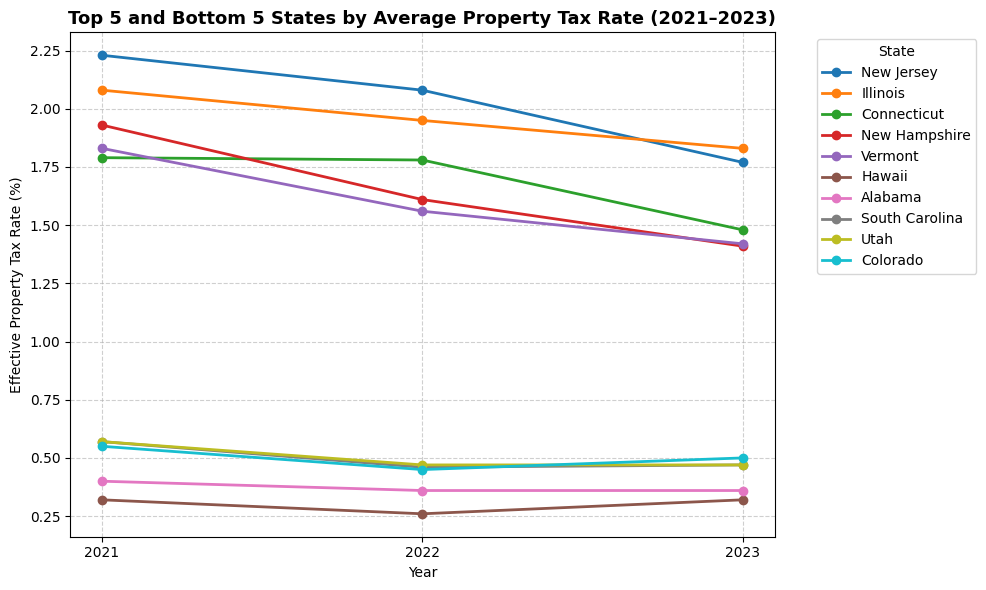


----------------------------------------------------------------------------- 



In [12]:
# ----------------------------------------------------
# 1. State & Local Property Tax (Effective Rates by State)
# ----------------------------------------------------

# Dataset: State & local property tax (aggregate)
# Public Source/URL: https://taxfoundation.org/data/all/state/property-taxes-by-state-county/
# Remarks & tips: Download the tax rates data for all past 3 years and take average of it.


tax_df = pd.read_csv(capstone_data_base_path + 'state_property_tax_rates_3yr_avg.csv')
print(tax_df.head())
print("Unique states:", tax_df['state'].nunique())
print('\n')

# Sort to find top 5 and bottom 5 states by 3-year average
top5 = tax_df.nlargest(5, 'tax_rate_3yr_avg')
bottom5 = tax_df.nsmallest(5, 'tax_rate_3yr_avg')

# Combine both groups for comparison
plot_df = pd.concat([top5, bottom5])

# Melt to long format for plotting
melted = plot_df.melt(
    id_vars='state',
    value_vars=['rate_2021', 'rate_2022', 'rate_2023'],
    var_name='year',
    value_name='rate'
)

# Clean the year column (extract digits only)
melted['year'] = melted['year'].str.extract(r'(\d{4})')

# Plot line chart
plt.figure(figsize=(10,6))
for s in melted['state'].unique():
    subset = melted[melted['state'] == s]
    plt.plot(subset['year'], subset['rate'] * 100, marker='o', linewidth=2, label=s)

# Chart formatting
plt.title("Top 5 and Bottom 5 States by Average Property Tax Rate (2021–2023)", fontsize=13, weight='bold')
plt.ylabel("Effective Property Tax Rate (%)")
plt.xlabel("Year")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc='upper left')
# Save this image
plt.savefig(capstone_figures_base_path + 'top5_bottom5_state_property_tax_rates.png')
plt.tight_layout()
plt.show()

print('\n----------------------------------------------------------------------------- \n')



/usr/local/lib/python3.12/dist-packages/kaleido/_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




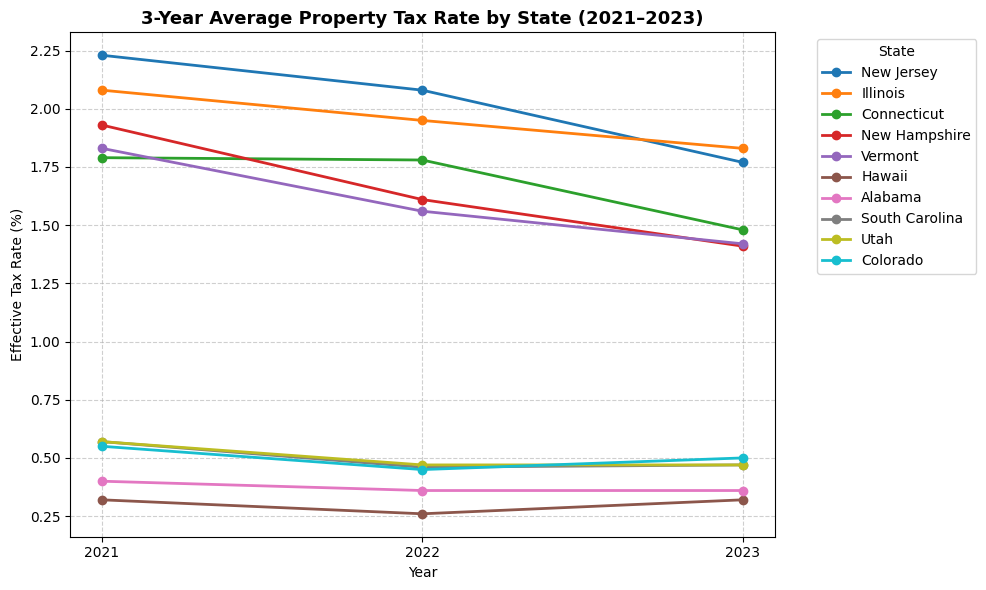

In [13]:
# ----------------------------------------------------
# 1.a Visualization: U.S. Choropleth - 3-Year Avg Property Tax Rate
# ----------------------------------------------------

import plotly.express as px

# Clean state names (Plotly expects state abbreviations)
# We'll map full state names to their 2-letter codes.
us_state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
    'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA',
    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

tax_df['state_code'] = tax_df['state'].map(us_state_abbrev)

# Create the choropleth
fig = px.choropleth(
    tax_df,
    locations='state_code',
    locationmode='USA-states',
    color='tax_rate_3yr_avg',
    hover_name='state',
    color_continuous_scale='Reds',
    range_color=(tax_df['tax_rate_3yr_avg'].min(), tax_df['tax_rate_3yr_avg'].max()),
    scope='usa',
    title='3-Year Average Property Tax Rate by State (2021–2023)',
    labels={'tax_rate_3yr_avg': 'Effective Tax Rate'}
)

# Improve layout
fig.update_layout(
    title_x=0.5,
    geo=dict(bgcolor='rgba(0,0,0,0)'),
    font=dict(size=12),
    coloraxis_colorbar=dict(title='Effective Tax Rate (%)')
)

# Convert to percentage for hover display
fig.update_traces(
    hovertemplate="<b>%{hovertext}</b><br>Tax Rate: %{z:.2%}<extra></extra>"
)

# Show interactive map
fig.show()

# could you use plt instead of flg ?
plt.figure(figsize=(10,6))
# Use the melted dataframe for the matplotlib plot as well
for s in melted['state'].unique():
    subset = melted[melted['state'] == s]
    plt.plot(subset['year'], subset['rate'] * 100, marker='o', linewidth=2, label=s)

plt.title('3-Year Average Property Tax Rate by State (2021–2023)', fontsize=13, weight='bold')
plt.ylabel('Effective Tax Rate (%)')
plt.xlabel('Year')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

#Save this figure
plt.savefig(capstone_figures_base_path + 'state_property_tax_rate_choropleth.png')

plt.tight_layout()
plt.show()

In [19]:
# ----------------------------------------------------
# 2. Tax / State Tax Collections Series (ZIP-compatible)
# ----------------------------------------------------
# Purpose: fetch state-level property & total tax series from FRED,
# compute property_tax_share, resample to MONTHLY (month-start),
# so it can be merged later onto ZIP data by ['state', 'date'].

import os, requests, pandas as pd
from io import StringIO

# Ensure out dir exists
os.makedirs(capstone_data_base_path_out_dir, exist_ok=True)

# USPS 2-letter state codes
states = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY",
          "LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND",
          "OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]

def fetch_fred_series(series_id: str) -> pd.DataFrame | None:
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"
    r = requests.get(url, timeout=30)
    if r.ok and r.text.strip():
        df = pd.read_csv(StringIO(r.text))
        # FRED headers are usually DATE,<series_id>
        df.columns = ["date", series_id]
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.dropna(subset=["date"])
        return df
    print(f"⚠️ Failed to fetch {series_id}")
    return None

frames, missing_states = [], []

for s in states:
    prop_id = f"{s}PROPTAX"   # Property taxes (often annual/quarterly)
    tot_id  = f"{s}TOTLTAX"   # Total taxes

    df_prop = fetch_fred_series(prop_id)
    if df_prop is None:
      df_prop = fetch_fred_series(f"{s}PROPTAXA")

    df_tot  = fetch_fred_series(tot_id)

    if df_prop is None or df_tot is None:
        missing_states.append(s)
        continue

    merged = df_prop.merge(df_tot, on="date", how="inner")
    merged["state"] = s
    # Rename dynamic columns to stable names
    merged = merged.rename(columns={
        prop_id: "property_tax_usd_millions",
        tot_id:  "total_tax_usd_millions"
    })
    # Compute share (safe divide)
    merged["property_tax_share"] = (
        merged["property_tax_usd_millions"] / merged["total_tax_usd_millions"]
    )

    # --- ZIP compatibility: monthly, month-start, forward-fill within state ---
    # 1) Set monthly index
    merged["date"] = pd.to_datetime(merged["date"], errors="coerce")
    merged = merged.dropna(subset=["date"]).sort_values("date")

    # 2) Create a complete monthly date index per state and ffill
    #    (FRED series may be annual/quarterly; we need monthly to align with Zillow.)
    # Build a monthly index for the full span of this state's series
    m_start, m_end = merged["date"].min(), merged["date"].max()
    monthly_idx = pd.date_range(m_start.to_period("M").to_timestamp(),
                                m_end.to_period("M").to_timestamp(),
                                freq="MS")

    merged = (
        merged.set_index("date")
              .reindex(monthly_idx)
              .rename_axis("date")
              .assign(state=s)
              .ffill()
              .reset_index()
    )

    # Keep tidy columns
    merged = merged[[
        "date", "state",
        "property_tax_usd_millions", "total_tax_usd_millions", "property_tax_share"
    ]]

    frames.append(merged)

# Combine all states
if frames:
    combined = pd.concat(frames, ignore_index=True)
    # Ensure month-start alignment
    combined["date"] = pd.to_datetime(combined["date"]).dt.to_period("M").dt.to_timestamp()
    out_file = capstone_data_base_path_out_dir + "state_tax_collections_monthly.csv"
    combined.to_csv(out_file, index=False)

    print(f"✅ Saved: {out_file}")
    print("Rows:", len(combined),
          "| States:", combined["state"].nunique(),
          "| Date range:", combined["date"].min(), "→", combined["date"].max())
else:
    print("⚠️ No state tax data fetched; check network or FRED availability.")

if missing_states:
    print(f"⚠️ Missing or incomplete states ({len(missing_states)}): {sorted(missing_states)}")

⚠️ Failed to fetch DEPROPTAX
⚠️ Failed to fetch DEPROPTAXA
⚠️ Failed to fetch HIPROPTAX
⚠️ Failed to fetch HIPROPTAXA
⚠️ Failed to fetch IAPROPTAX
⚠️ Failed to fetch IAPROPTAXA
⚠️ Failed to fetch NYPROPTAX
⚠️ Failed to fetch NYPROPTAXA
⚠️ Failed to fetch OKPROPTAX
⚠️ Failed to fetch OKPROPTAXA
⚠️ Failed to fetch SDPROPTAX
⚠️ Failed to fetch SDPROPTAXA
⚠️ Failed to fetch TNPROPTAX
⚠️ Failed to fetch TNPROPTAXA
⚠️ Failed to fetch TXPROPTAX
⚠️ Failed to fetch TXPROPTAXA
✅ Saved: /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/state_tax_collections_monthly.csv
Rows: 40398 | States: 42 | Date range: 1942-01-01 00:00:00 → 2024-01-01 00:00:00
⚠️ Missing or incomplete states (8): ['DE', 'HI', 'IA', 'NY', 'OK', 'SD', 'TN', 'TX']


In [24]:
# ----------------------------------------------------
# 3. Mortgage Rate Archive (Alternate / Historical Source)
# ----------------------------------------------------

# Dataset: Mortgage rate archive
# Public Source/URL: Freddie Mac’s PMMS (Mortgage Rates) page
# Remarks & tips: Official source for mortgage rates. Use their archives.


# ----------------------------------------------------
# Dataset: Freddie Mac PMMS (Primary Mortgage Market Survey)
# ----------------------------------------------------
# Source: https://www.freddiemac.com/pmms/pmms_archives
# Columns: date, pmms30, pmms30p, pmms15, pmms15p, pmms51, pmms51p, pmms51m, pmms51spread
# ----------------------------------------------------

import pandas as pd

# Load the downloaded CSV
pmms = pd.read_csv(capstone_data_base_path + "freddie_mac_pmms.csv")

# Clean column names
pmms.columns = [c.strip().lower() for c in pmms.columns]

# Parse the date column
pmms['date'] = pd.to_datetime(pmms['date'])

# Select relevant columns
# pmms30, pmms15, pmms51 are the interest rates (in %)
# The 'p' versions (pmms30p, pmms15p, pmms51p) represent "points" or fees
pmms_clean = pmms[['date', 'pmms30', 'pmms15', 'pmms51']].copy()

# Convert string or percentage-like values to numeric decimals
for col in ['pmms30', 'pmms15', 'pmms51']:
    pmms_clean[col] = (
        pmms_clean[col]
        .astype(str)
        .str.replace('%', '', regex=False)
        .str.replace(',', '', regex=False)
        .astype(float)
    ) / 100  # convert from % to decimal (e.g., 6.5 → 0.065)

# Rename for clarity
pmms_clean.rename(
    columns={
        'pmms30': 'freddie_30yr_rate',
        'pmms15': 'freddie_15yr_rate',
        'pmms51': 'freddie_5_1_arm_rate'
    },
    inplace=True
)

# Sort and save
pmms_clean = pmms_clean.sort_values('date')
pmms_clean.to_csv(capstone_data_base_path + "freddie_mac_pmms_clean.csv", index=False)

print("✅ Cleaned Freddie Mac PMMS data saved to data/freddie_mac_pmms_clean.csv")
print(pmms_clean.head())


✅ Cleaned Freddie Mac PMMS data saved to data/freddie_mac_pmms_clean.csv
        date  freddie_30yr_rate  freddie_15yr_rate  freddie_5_1_arm_rate
0 1971-04-02             0.0733                NaN                   NaN
1 1971-04-09             0.0731                NaN                   NaN
2 1971-04-16             0.0731                NaN                   NaN
3 1971-04-23             0.0731                NaN                   NaN
4 1971-04-30             0.0729                NaN                   NaN


In [25]:
# Merge with FRED 30-Year Mortgage Rate
# Load FRED mortgage rate data
fred = pd.read_csv(capstone_data_base_path + "fred_mortgage_rate.csv")
fred['date'] = pd.to_datetime(fred['date'])

# Merge the two datasets (match on closest previous date)
merged_rates = pd.merge_asof(
    pmms_clean.sort_values("date"),
    fred.sort_values("date"),
    on="date",
    direction="backward"
)

merged_rates.rename(columns={'MORTGAGE30US': 'fred_30yr_rate'}, inplace=True)
merged_rates.to_csv(capstone_data_base_path + "mortgage_rates_combined.csv", index=False)
print("✅ Saved merged dataset as data/mortgage_rates_combined.csv")


✅ Saved merged dataset as data/mortgage_rates_combined.csv


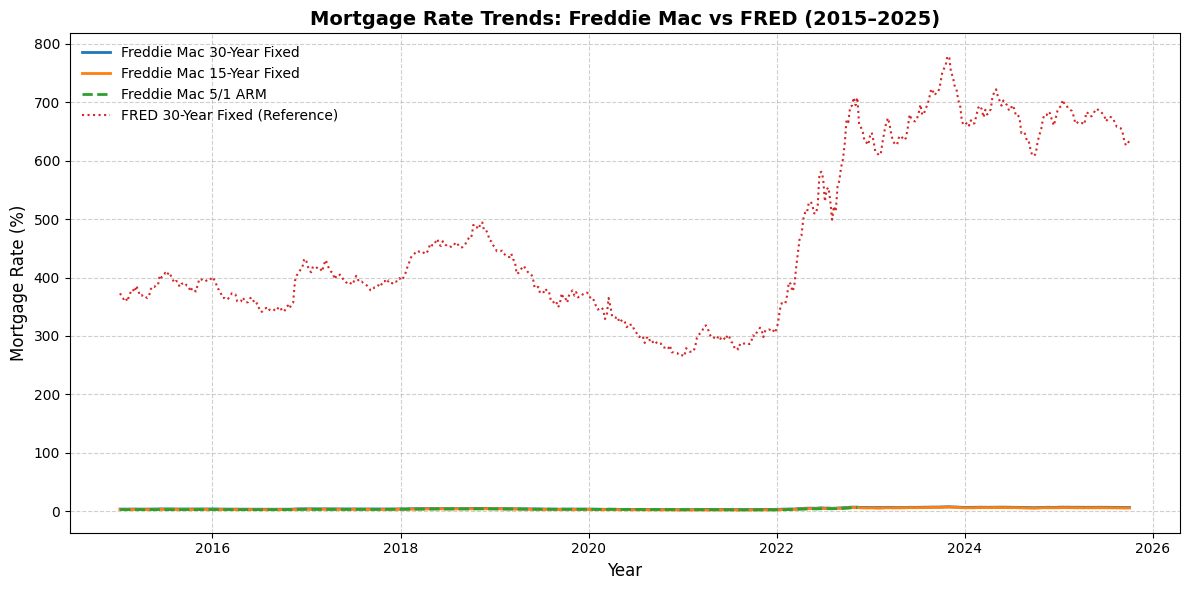

In [26]:
# ----------------------------------------------------
# Visualization: Mortgage Rate Trends (Freddie Mac vs FRED)
# ----------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt

# Load the combined dataset
rates = pd.read_csv(capstone_data_base_path + "mortgage_rates_combined.csv")
rates['date'] = pd.to_datetime(rates['date'])

# Convert decimals to percentages for readability
for col in ['freddie_30yr_rate', 'freddie_15yr_rate', 'freddie_5_1_arm_rate', 'fred_30yr_rate']:
    rates[col] = rates[col] * 100

# Filter last 10 years for clarity (optional)
rates_recent = rates[rates['date'] >= "2015-01-01"]

# Plot
plt.figure(figsize=(12,6))
plt.plot(rates_recent['date'], rates_recent['freddie_30yr_rate'], label='Freddie Mac 30-Year Fixed', linewidth=2)
plt.plot(rates_recent['date'], rates_recent['freddie_15yr_rate'], label='Freddie Mac 15-Year Fixed', linewidth=2)
plt.plot(rates_recent['date'], rates_recent['freddie_5_1_arm_rate'], label='Freddie Mac 5/1 ARM', linewidth=2, linestyle='--')
plt.plot(rates_recent['date'], rates_recent['fred_30yr_rate'], label='FRED 30-Year Fixed (Reference)', linewidth=1.5, linestyle=':')

# Aesthetics
plt.title("Mortgage Rate Trends: Freddie Mac vs FRED (2015–2025)", fontsize=14, weight='bold')
plt.ylabel("Mortgage Rate (%)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', frameon=False)
# Save this figure
plt.savefig(capstone_figures_base_path + 'mortgage_rate_trends.png')
plt.tight_layout()
plt.show()


In [20]:
# ----------------------------------------------------
# Step 1 — Load and Normalize Individual Datasets + ZIP Overlap Diagnostics
# ----------------------------------------------------
# Purpose: This section loads the raw data files for Zillow prices (ZHVI),
# Zillow rents (ZORI), FRED mortgage rates, state-level tax data, state-level
# cost parameters, and state/year growth history. It then performs initial
# normalization steps on each DataFrame to prepare them for merging.
# Finally, it includes diagnostic checks to analyze the overlap between the
# ZIP-level price and rent data, which is important for understanding the
# data coverage before the main merge.

import pandas as pd
from pathlib import Path

# ---- Paths (use your /out/ files) ----
# Define the file paths for all the input datasets.
# capstone_data_base_path_out_dir is used for files generated in previous steps (like cleaned Zillow data).
# capstone_data_base_path is used for manually added or original downloaded files.
prices_path = Path(capstone_data_base_path_out_dir) / "zillow_zip_prices.csv"
rents_path  = Path(capstone_data_base_path_out_dir) / "zillow_zip_rents.csv"
fred_path   = Path(capstone_data_base_path) / "fred_mortgage_rate.csv"
tax_path    = Path(capstone_data_base_path) / "state_property_tax_rates_3yr_avg.csv"
cost_path   = Path(capstone_data_base_path) / "state_cost_params.csv"
share_path  = Path(capstone_data_base_path_out_dir) / "state_tax_collections_monthly.csv" # Use the monthly file generated earlier
growth_path = Path(capstone_data_base_path) / "growth_history.csv"

# ---- Helper function to load and perform basic normalization ----
# This function abstracts the common loading and initial cleaning steps.
def _load_norm(path):
    """
    Loads a CSV, strips whitespace from columns, normalizes ZIP codes to 5 digits,
    renames a 'State' column to 'state' if present, and parses a 'date' column.
    """
    # Check if the file exists before attempting to read
    if not Path(path).exists():
        print(f"⚠️ Warning: File not found at {path}. Returning None.")
        return None

    df = pd.read_csv(path, low_memory=False)
    # strip headers - Remove leading/trailing whitespace from column names
    df.columns = df.columns.str.strip()
    # normalize zip + state naming - Clean and standardize 'zip' and 'state' columns
    if "zip" in df.columns:
        df["zip"] = df["zip"].astype(str).str.zfill(5) # Pad ZIP codes with leading zeros to ensure 5 digits
    if "State" in df.columns and "state" not in df.columns:
        df = df.rename(columns={"State": "state"}) # Rename 'State' to 'state' for consistency
    # parse date - Convert a 'date' column to datetime objects
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce") # Use errors='coerce' to turn unparseable dates into NaT (Not a Time)
    return df

# ---- Load DataFrames using the helper function ----
# Load each dataset, using the helper function for initial cleaning.
# Check if the file exists before loading to prevent errors.
prices = _load_norm(prices_path)
rents  = _load_norm(rents_path)
fred   = _load_norm(fred_path)   if fred_path.exists()   else None # Only load if FRED file exists
tax    = _load_norm(tax_path)    if tax_path.exists()    else None # Only load if tax file exists
cost   = _load_norm(cost_path)   if cost_path.exists()   else None # Only load if cost file exists
share  = _load_norm(share_path)  if share_path.exists()  else None # Only load if share file exists
growth = _load_norm(growth_path) if growth_path.exists() else None # Only load if growth file exists


# ---- Quick peeks ----
# Print the column names of the loaded DataFrames to quickly inspect them.
print("prices cols:", prices.columns.tolist()[:10] if prices is not None else "prices DataFrame is None")
print("rents   cols:", rents.columns.tolist()[:10] if rents is not None else "rents DataFrame is None")

# State coverage (sanity check) - Check and print sample state values if the 'state' column exists.
if prices is not None and "state" in prices.columns:
    print("prices states sample:", prices["state"].dropna().unique()[:10])
if rents is not None and "state" in rents.columns:
    print("rents   states sample:", rents["state"].dropna().unique()[:10])

# Date ranges - Print the date range for price and rent data.
if prices is not None and "date" in prices.columns:
    print("prices date range:", prices["date"].min(), "→", prices["date"].max())
else:
    print("prices date range: Not available (DataFrame or 'date' column missing)")

if rents is not None and "date" in rents.columns:
    print("rents   date range:", rents["date"].min(),   "→", rents["date"].max())
else:
     print("rents date range: Not available (DataFrame or 'date' column missing)")


# ---- ZIP overlap diagnostics ----
# Perform diagnostic checks to understand the overlap of ZIP codes and ZIP-date pairs
# between the prices and rents DataFrames. This helps identify potential data gaps
# before the main merge.
if prices is not None and rents is not None and "zip" in prices.columns and "zip" in rents.columns:
    # Compare unique ZIPs - Find ZIP codes present in one DataFrame but not the other.
    print("ZIPs only in prices:", sorted(set(prices["zip"]) - set(rents["zip"]))[:10])
    print("ZIPs only in rents:",   sorted(set(rents["zip"])  - set(prices["zip"]))[:10])

    # Compare on (zip, date) pairs - Find specific ZIP-date combinations present in one but not the other.
    # This is a more granular check than just unique ZIPs.
    p_pairs = set(zip(prices["zip"], prices["date"]))
    r_pairs = set(zip(rents["zip"],  rents["date"]))
    print("Pairs only in prices:", len(p_pairs - r_pairs))
    print("Pairs only in rents:",   len(r_pairs - p_pairs))

    # Outer merge on (zip, date) to see mismatches - Perform an outer merge to visually
    # inspect rows that do not have a match in the other DataFrame.
    probe = prices.merge(rents, on=["zip","date"], how="outer", indicator="_merge", suffixes=("_price","_rent"))
    print(probe["_merge"].value_counts())

    # Show a few non-matching examples - Display the head of rows that are only in
    # prices (left_only) or only in rents (right_only).
    print("\nLeft-only (in prices, missing in rents):")
    display(probe.loc[probe["_merge"]=="left_only"].head(5))

    print("\nRight-only (in rents, missing in prices):")
    display(probe.loc[probe["_merge"]=="right_only"].head(5))
else:
    print("\n⚠️ Cannot perform ZIP overlap diagnostics: prices or rents DataFrame, or 'zip' column is missing.")

prices cols: ['zip', 'date', 'state', 'City', 'Metro', 'county_name', 'median_price']
rents   cols: ['zip', 'date', 'state', 'City', 'Metro', 'county_name', 'median_rent']
prices states sample: ['MA' 'RI' 'NH' 'ME' 'VT' 'CT' 'NJ' 'NY' 'PA' 'DE']
rents   states sample: ['MA' 'RI' 'NH' 'ME' 'VT' 'CT' 'NJ' 'NY' 'PA' 'DE']
prices date range: 2000-01-31 00:00:00 → 2025-09-30 00:00:00
rents   date range: 2015-01-01 00:00:00 → 2025-09-01 00:00:00
ZIPs only in prices: ['01001', '01005', '01007', '01008', '01010', '01011', '01012', '01020', '01022', '01026']
ZIPs only in rents: ['10038', '10162', '11109', '12207', '14203', '14604', '20701', '31421', '37228', '44308']
Pairs only in prices: 6197026
Pairs only in rents: 396164
_merge
left_only     6197026
right_only     396164
both                0
Name: count, dtype: int64

Left-only (in prices, missing in rents):


,zip,date,state_price,City_price,Metro_price,county_name_price,median_price,state_rent,City_rent,Metro_rent,county_name_rent,median_rent,_merge
0,01001,2000-01-31,MA,Agawam,"Springfield, MA",Hampden County,121926.0,NaN,NaN,NaN,NaN,NaN,left_only
1,01001,2000-02-29,MA,Agawam,"Springfield, MA",Hampden County,121880.0,NaN,NaN,NaN,NaN,NaN,left_only
2,01001,2000-03-31,MA,Agawam,"Springfield, MA",Hampden County,122027.0,NaN,NaN,NaN,NaN,NaN,left_only
3,01001,2000-04-30,MA,Agawam,"Springfield, MA",Hampden County,122359.0,NaN,NaN,NaN,NaN,NaN,left_only
4,01001,2000-05-31,MA,Agawam,"Springfield, MA",Hampden County,123219.0,NaN,NaN,NaN,NaN,NaN,left_only



Right-only (in rents, missing in prices):


,zip,date,state_price,City_price,Metro_price,county_name_price,median_price,state_rent,City_rent,Metro_rent,county_name_rent,median_rent,_merge
592,01002,2023-08-01,NaN,NaN,NaN,NaN,NaN,MA,Amherst,"Springfield, MA",Hampshire County,2587.0,right_only
594,01002,2023-09-01,NaN,NaN,NaN,NaN,NaN,MA,Amherst,"Springfield, MA",Hampshire County,2588.0,right_only
596,01002,2023-10-01,NaN,NaN,NaN,NaN,NaN,MA,Amherst,"Springfield, MA",Hampshire County,2562.0,right_only
598,01002,2023-11-01,NaN,NaN,NaN,NaN,NaN,MA,Amherst,"Springfield, MA",Hampshire County,2579.0,right_only
600,01002,2023-12-01,NaN,NaN,NaN,NaN,NaN,MA,Amherst,"Springfield, MA",Hampshire County,2620.0,right_only


In [21]:
# ----------------------------------------------------
# Step 2 — Normalize States and Dates
# ----------------------------------------------------
# Purpose: This section performs crucial normalization steps on the loaded
# DataFrames to ensure consistency before merging. Specifically, it standardizes
# state names to a consistent 2-letter USPS code format and standardizes
# the date columns to represent the start of the month for the Zillow data.
# Consistent state names and date formats are essential for accurate merging
# of data from different sources.

# 2) Normalize states and dates (robust fix)
# --- A) Standardize STATE names to USPS 2-letter codes everywhere ---
# Defines dictionaries for mapping full state names to 2-letter codes and vice-versa.
name_to_code = {
    'Alabama':'AL','Alaska':'AK','Arizona':'AZ','Arkansas':'AR','California':'CA','Colorado':'CO',
    'Connecticut':'CT','Delaware':'DE','FL':'FL','GA':'GA','HI':'HI','ID':'ID','IL':'IL','IN':'IN','IA':'IA','KS':'KS','KY':'KY',
    'LA':'LA','ME':'ME','MD':'MD','MA':'MA','MI':'MI','MN':'MN','MS':'MS','MO':'MO','MT':'MT','NE':'NE','NV':'NV','NH':'NH','NJ':'NJ','NM':'NM','NY':'NY','NC':'NC','ND':'ND',
    'OH':'OH','OK':'OK','OR':'OR','PA':'PA','RI':'RI','SC':'SC','SD':'SD','TN':'TN','TX':'TX','UT':'UT','VT':'VT','VA':'VA','WA':'WA','WV':'WV','WI':'WI','WY':'WY',
    'District of Columbia':'DC' # Added District of Columbia mapping
}
code_to_name = {v:k for k,v in name_to_code.items()}

# Helper function to standardize the state column in a DataFrame.
def normalize_state_col(df, col='state'):
    """
    Standardizes the specified state column in a DataFrame to USPS 2-letter codes.
    Tries mapping full names and falls back to uppercasing existing codes.
    """
    if col not in df.columns:
        print(f"⚠️ Warning: Column '{col}' not found in DataFrame.")
        return df # Return original df if column not found

    s = df[col].astype(str).str.strip()
    # Try map full-name → code
    mapped = s.map(name_to_code)
    # If many NAs, we probably already have codes; keep s where mapped is NA
    df[col] = mapped.fillna(s.str.upper())  # ensure codes upper
    return df

# Apply state normalization to relevant DataFrames if they exist.
if prices is not None:
  prices  = normalize_state_col(prices, 'state')
if rents is not None:
  rents   = normalize_state_col(rents,  'state')
if tax is not None:
  tax     = normalize_state_col(tax,    'state')
if cost is not None:
  cost    = normalize_state_col(cost,   'state')
if share is not None:
  share   = normalize_state_col(share,  'state')
# growth is annual by state name in your sample; normalize too
if growth is not None:
  growth  = normalize_state_col(growth, 'state')

# --- B) Standardize DATE to month-start everywhere for Zillow files ---
# Helper function to convert a date column to month-start.
def to_month_start(df, col='date'):
    """
    Converts the specified date column in a DataFrame to datetime objects
    and then floors them to the first day of the month.
    """
    if col not in df.columns:
        print(f"⚠️ Warning: Date column '{col}' not found in DataFrame.")
        return df # Return original df if column not found
    df[col] = pd.to_datetime(df[col], errors='coerce')
    # Floor all dates to the first of the month
    df[col] = df[col].dt.to_period('M').dt.to_timestamp()
    return df

# Apply date standardization to Zillow DataFrames if they exist.
# FRED dates are kept as they are (weekly) for the asof merge later.
if prices is not None:
  prices = to_month_start(prices, 'date')
if rents is not None:
  rents  = to_month_start(rents,  'date')
if fred is not None:
  fred['date'] = pd.to_datetime(fred['date'])  # keep as real dates (weekly)
  print("\nFRED DataFrame head after date parsing:")
  display(fred.head()) # Use display for better formatting


FRED DataFrame head after date parsing:


,date,MORTGAGE30US
0,2000-01-07,8.15
1,2000-01-14,8.18
2,2000-01-21,8.26
3,2000-01-28,8.25
4,2000-02-04,8.25


In [22]:
# ----------------------------------------------------
# STEP 3 — ZIP-LEVEL RE-MERGE WITH SANITY CHECKS
# ----------------------------------------------------
"""
Goal
-----
Build the master `housing` DataFrame at ZIP × month granularity that feeds the
Buy vs Rent modeling. We consolidate:
  • Zillow: ZIP-level median home prices  (`prices`)
  • Zillow: ZIP-level median rents        (`rents`)
  • FRED:   weekly mortgage rate series   (`fred`)
  • State-level tax params                 (`tax`)   -> tax_rate_3yr_avg
  • State-level cost params                (`cost`)  -> insurance_pct, maintenance_pct
  • State-level tax share                  (`share`) -> property_tax_share (by state & date)
  • State/year growth                      (`growth`)

Key Notes
---------
• Primary merge grain is ('zip','date') for Zillow.
• State-level tables merge on 'state' (and sometimes 'date'/'year').
• We coalesce any duplicate state columns (e.g., 'State_price'/'State_rent') into one 'state'.
• As-of join maps each monthly row to the most recent available FRED rate on or before the date.
• After merges we assert the presence of tax_rate_3yr_avg, insurance_pct, maintenance_pct.
"""

import pandas as pd

# ---------- 0) Helpers: robust schema normalization ----------

def _strip_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Trim whitespace from column names (Zillow occasionally has stray spaces)."""
    df = df.copy()
    df.columns = df.columns.str.strip()
    return df

def _canonicalize_state_from(df: pd.DataFrame,
                             candidates=("state","State","state_price","state_rent","State_price","State_rent")) -> pd.DataFrame:
    """
    Build a single 'state' USPS 2-letter column by coalescing any available candidates
    that may have arisen during earlier merges (e.g., from prices/rents).
    """
    df = df.copy()
    cols = [c for c in candidates if c in df.columns]
    if not cols:
        return df
    s = None
    for c in cols:
        s = df[c] if s is None else s.fillna(df[c])
    df["state"] = s.astype(str).str.strip().str.upper()
    # Keep only valid two-letter codes; others to NA
    df["state"] = df["state"].where(df["state"].str.fullmatch(r"[A-Z]{2}"))
    # Drop source state columns (keep only our canonical 'state')
    for c in cols:
        if c != "state":
            df.drop(columns=c, inplace=True, errors="ignore")
    return df

def _ensure_tax_schema(df: pd.DataFrame | None) -> pd.DataFrame | None:
    if df is None: return None
    df = _strip_cols(df.copy())
    # Normalize key names if they drift
    rename_map = {}
    if "state" not in df.columns and "State" in df.columns:
        rename_map["State"] = "state"
    if "tax_rate_3yr_avg" not in df.columns:
        for alt in ["eff_property_tax_rate_3yr_avg", "property_tax_rate_3yr_avg", "tax_rate"]:
            if alt in df.columns:
                rename_map[alt] = "tax_rate_3yr_avg"; break
    if rename_map:
        df = df.rename(columns=rename_map)
    if "state" in df.columns:
        df["state"] = df["state"].astype(str).str.strip().str.upper()
        df = df.drop_duplicates(subset=["state"], keep="last")
    return df

def _ensure_cost_schema(df: pd.DataFrame | None) -> pd.DataFrame | None:
    if df is None: return None
    df = _strip_cols(df.copy())
    rename_map = {}
    if "state" not in df.columns and "State" in df.columns:
        rename_map["State"] = "state"
    if "insurance_pct" not in df.columns:
        for alt in ["home_insurance_pct", "ins_pct"]:
            if alt in df.columns:
                rename_map[alt] = "insurance_pct"; break
    if "maintenance_pct" not in df.columns:
        for alt in ["maint_pct", "maintenance_rate"]:
            if alt in df.columns:
                rename_map[alt] = "maintenance_pct"; break
    if rename_map:
        df = df.rename(columns=rename_map)
    if "state" in df.columns:
        df["state"] = df["state"].astype(str).str.strip().str.upper()
        df = df.drop_duplicates(subset=["state"], keep="last")
    return df

def _ensure_share_schema(df: pd.DataFrame | None) -> pd.DataFrame | None:
    if df is None: return None
    df = _strip_cols(df.copy())
    # Expect: ['date','state','property_tax_share']
    if "state" not in df.columns and "State" in df.columns:
        df = df.rename(columns={"State":"state"})
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.to_period("M").dt.to_timestamp()
    if "state" in df.columns:
        df["state"] = df["state"].astype(str).str.strip().str.upper()
    return df

def _ensure_growth_schema(df: pd.DataFrame | None) -> pd.DataFrame | None:
    if df is None: return None
    df = _strip_cols(df.copy())
    # Expect at least ['state','year', ...]
    if "state" not in df.columns and "State" in df.columns:
        df = df.rename(columns={"State":"state"})
    if "state" in df.columns:
        df["state"] = df["state"].astype(str).str.strip().str.upper()
    if "year" in df.columns:
        df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    return df

# ---------- 1) Zillow prices + rents (ZIP × month) ----------

# Basic hygiene (strip headers, normalize zip/date)
prices = _strip_cols(prices); rents = _strip_cols(rents)
for df in (prices, rents):
    if "zip" in df.columns:
        df["zip"] = df["zip"].astype(str).str.zfill(5)
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.to_period("M").dt.to_timestamp()

if prices is not None and rents is not None:
    # Inner join: keep only ZIP-date pairs present in BOTH Zillow tables
    housing = prices.merge(
        rents,
        on=["zip","date"],
        how="inner",
        suffixes=("_price","_rent")
    )
    print("After price+rent:", housing.shape)
    print("Columns:", housing.columns.tolist()[:20], "...")
else:
    print("⚠️ prices and/or rents are missing; cannot proceed.")
    housing = pd.DataFrame()

# Recover/standardize a single 'state' column before any state-level merges
housing = _canonicalize_state_from(housing)
if "state" not in housing.columns:
    print("⚠️ No 'state' column present after coalescing; state-level merges will be skipped.")

# ---------- 2) Attach FRED mortgage rate via as-of join (weekly → monthly) ----------
if not housing.empty and fred is not None and "date" in fred.columns:
    fred = fred.copy()
    fred.columns = fred.columns.str.strip()
    # Expect something like ['date','mortgage_rate'] — keep all numeric cols besides 'date'
    fred["date"] = pd.to_datetime(fred["date"], errors="coerce")
    fred = fred.dropna(subset=["date"]).sort_values("date")
    housing = pd.merge_asof(
        housing.sort_values("date"),
        fred.sort_values("date"),
        on="date",
        direction="backward"  # pick last known rate on/before the ZIP month
    )
    print("After asof FRED:", housing.shape)
else:
    print("⚠️ Skipping FRED merge (missing 'housing' or 'fred').")

# ---------- 3) Merge state-level tax/cost/share ----------
tax_fixed   = _ensure_tax_schema(tax)
cost_fixed  = _ensure_cost_schema(cost)
share_fixed = _ensure_share_schema(share)

# 3a) Tax rate (tax_rate_3yr_avg) — left join by state
if not housing.empty and tax_fixed is not None and "state" in housing.columns:
    if {"state","tax_rate_3yr_avg"}.issubset(tax_fixed.columns):
        before = housing.shape[0]
        housing = housing.merge(
            tax_fixed[["state","tax_rate_3yr_avg"]],
            on="state",
            how="left"
        )
        print(f"After tax merge: {housing.shape} (Δrows {housing.shape[0]-before})")
    else:
        print("⚠️ tax table missing 'tax_rate_3yr_avg'.")

# 3b) Cost params (insurance_pct, maintenance_pct) — left join by state
if not housing.empty and cost_fixed is not None and "state" in housing.columns:
    needed = {"state","insurance_pct","maintenance_pct"}
    if needed.issubset(cost_fixed.columns):
        before = housing.shape[0]
        housing = housing.merge(
            cost_fixed[list(needed)],
            on="state",
            how="left"
        )
        print(f"After cost merge: {housing.shape} (Δrows {housing.shape[0]-before})")
    else:
        print("⚠️ cost table missing one of: 'insurance_pct','maintenance_pct'.")

# 3c) Property tax share (state, date) — left join by state & month
if not housing.empty and share_fixed is not None and {"state","date","property_tax_share"}.issubset(share_fixed.columns):
    before = housing.shape[0]
    housing = housing.merge(
        share_fixed[["state","date","property_tax_share"]],
        on=["state","date"],
        how="left"
    )
    print(f"After share merge: {housing.shape} (Δrows {housing.shape[0]-before})")

print("After all state-level merges:", housing.shape)

# ---------- 4) Merge annual growth by (state, year) ----------
growth_fixed = _ensure_growth_schema(growth)
if not housing.empty and growth_fixed is not None and "state" in housing.columns:
    housing["year"] = housing["date"].dt.year.astype("Int64")
    if {"state","year"}.issubset(growth_fixed.columns):
        before = housing.shape[0]
        housing = housing.merge(growth_fixed, on=["state","year"], how="left")
        print(f"After growth merge: {housing.shape} (Δrows {housing.shape[0]-before})")
    else:
        print("⚠️ growth table missing 'state' and/or 'year'.")

# ---------- 5) Sanity checks ----------
must_have = ["tax_rate_3yr_avg","insurance_pct","maintenance_pct"]
missing = [c for c in must_have if c not in housing.columns]
if missing:
    print("❌ Missing expected columns after merges:", missing)
else:
    print("✅ Expected columns present:", must_have)
    # Quick null shares
    for c in must_have:
        print(f"Null share {c}: {housing[c].isna().mean():.2%}")

print("Final housing shape:", housing.shape)
display(housing.head(5))


After price+rent: (395376, 12)
Columns: ['zip', 'date', 'state_price', 'City_price', 'Metro_price', 'county_name_price', 'median_price', 'state_rent', 'City_rent', 'Metro_rent', 'county_name_rent', 'median_rent'] ...
After asof FRED: (395376, 12)
After tax merge: (395376, 13) (Δrows 0)
After cost merge: (395376, 15) (Δrows 0)
After share merge: (395376, 16) (Δrows 0)
After all state-level merges: (395376, 16)
After growth merge: (395376, 19) (Δrows 0)
✅ Expected columns present: ['tax_rate_3yr_avg', 'insurance_pct', 'maintenance_pct']
Null share tax_rate_3yr_avg: 75.42%
Null share insurance_pct: 75.42%
Null share maintenance_pct: 75.42%
Final housing shape: (395376, 19)


,zip,date,City_price,Metro_price,county_name_price,median_price,City_rent,Metro_rent,county_name_rent,median_rent,state,MORTGAGE30US,tax_rate_3yr_avg,maintenance_pct,insurance_pct,property_tax_share,year,median_price_growth,median_rent_growth
0,76107,2015-01-01,Fort Worth,"Dallas-Fort Worth-Arlington, TX",Tarrant County,191828,Fort Worth,"Dallas-Fort Worth-Arlington, TX",Tarrant County,1010,TX,3.87,NaN,NaN,NaN,NaN,2015,NaN,NaN
1,11201,2015-01-01,New York,"New York-Newark-Jersey City, NY-NJ-PA",Kings County,1623075,New York,"New York-Newark-Jersey City, NY-NJ-PA",Kings County,3051,NY,3.87,NaN,NaN,NaN,NaN,2015,NaN,NaN
2,33126,2015-01-01,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",Miami-Dade County,151015,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",Miami-Dade County,1419,FL,3.87,NaN,NaN,NaN,0.000007,2015,NaN,NaN
3,32607,2015-01-01,Gainesville,"Gainesville, FL",Alachua County,144340,Gainesville,"Gainesville, FL",Alachua County,735,FL,3.87,NaN,NaN,NaN,0.000007,2015,NaN,NaN
4,33410,2015-01-01,Palm Beach Gardens,"Miami-Fort Lauderdale-Pompano Beach, FL",Palm Beach County,274866,Palm Beach Gardens,"Miami-Fort Lauderdale-Pompano Beach, FL",Palm Beach County,1305,FL,3.87,NaN,NaN,NaN,0.000007,2015,NaN,NaN


In [23]:
# ----------------------------------------------------
# STEP 4 — Recompute Derived Columns (ZIP-level, safe)
# ----------------------------------------------------
import numpy as np
import pandas as pd
from pathlib import Path

if not housing.empty:
    # --- 1) Basic hygiene: ensure numeric types where needed ---
    for col in ["median_price", "median_rent"]:
        if col in housing.columns:
            housing[col] = pd.to_numeric(housing[col], errors="coerce")

    # --- 2) Rent/Price derived metrics ---
    # Annual rent divided by price
    housing["rent_to_price_ratio"] = np.where(
        housing["median_price"].gt(0),
        (housing["median_rent"] * 12) / housing["median_price"],
        np.nan
    )
    # Inverse: how many years of rent equals price
    housing["price_to_rent_years"] = np.where(
        (housing["median_rent"] * 12).gt(0),
        housing["median_price"] / (housing["median_rent"] * 12),
        np.nan
    )

    # Clean up any inf/-inf that could sneak in from bad data
    housing["rent_to_price_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)
    housing["price_to_rent_years"].replace([np.inf, -np.inf], np.nan, inplace=True)

    # --- 3) Mortgage rate (decimal) ---
    # Prefer MORTGAGE30US if present; otherwise try to auto-detect a rate column from FRED
    rate_col = None
    if "MORTGAGE30US" in housing.columns:
        rate_col = "MORTGAGE30US"
    else:
        # Heuristic: first numeric column from FRED merge other than known Zillow columns
        known = {"zip","date","state","city","City","Metro","county_name",
                 "median_price","median_rent","rent_to_price_ratio","price_to_rent_years",
                 "tax_rate_3yr_avg","insurance_pct","maintenance_pct",
                 "property_tax_share","year"}
        candidates = [c for c in housing.columns if c not in known]
        for c in candidates:
            if pd.api.types.is_numeric_dtype(housing[c]):
                rate_col = c
                break

    if rate_col is not None:
        # Convert percent → decimal if needed
        # If max > 1 assume it's in percent (e.g. 7.3) else already decimal (0.073)
        max_val = pd.to_numeric(housing[rate_col], errors="coerce").max()
        housing["mortgage_rate"] = np.where(max_val is not None and max_val > 1.0,
                                            housing[rate_col] / 100.0,
                                            housing[rate_col])
    else:
        print("⚠️ Could not identify mortgage rate column from FRED merge; setting NaN.")
        housing["mortgage_rate"] = np.nan

    # --- 4) Ownership cost % components (all as decimals) ---
    # Expect these columns from Step-3 merges; compute total if available
    have_tax  = "tax_rate_3yr_avg" in housing.columns
    have_ins  = "insurance_pct"    in housing.columns
    have_maint= "maintenance_pct"  in housing.columns

    if have_tax and have_ins and have_maint:
        housing["total_annual_ownership_cost_pct"] = (
            housing["tax_rate_3yr_avg"].fillna(0.0) +
            housing["insurance_pct"].fillna(0.0) +
            housing["maintenance_pct"].fillna(0.0)
        )
    else:
        missing = [c for c in ["tax_rate_3yr_avg","insurance_pct","maintenance_pct"] if c not in housing.columns]
        print(f"⚠️ Missing for total_annual_ownership_cost_pct: {missing}")
        housing["total_annual_ownership_cost_pct"] = np.nan

    # --- 5) Optional: quick sanity bounds (clip extreme ratios to reduce outlier blowups) ---
    housing["rent_to_price_ratio"]  = housing["rent_to_price_ratio"].clip(lower=0, upper=1)
    housing["price_to_rent_years"]  = housing["price_to_rent_years"].clip(lower=0, upper=100)
    housing["mortgage_rate"]        = housing["mortgage_rate"].clip(lower=0, upper=0.25)  # 0–25% annual
    housing["total_annual_ownership_cost_pct"] = housing["total_annual_ownership_cost_pct"].clip(lower=0, upper=0.1)

    # --- 6) Save + spot-check ---
    print("Final shape:", housing.shape)
    display(housing.head(5))

    # Save to /out/ and optional local data/ mirror
    out_dir = Path(capstone_data_base_path_out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / "master_housing_dataset_zip.csv"

    housing.to_csv(out_path.as_posix(), index=False)

    # Optional local copy for quick access in repo
    Path("data").mkdir(exist_ok=True)
    housing.to_csv("data/master_housing_dataset_zip.csv", index=False)

    print("✅ Saved:", out_path)
    print("✅ Also saved: data/master_housing_dataset_zip.csv")

else:
    print("⚠️ Housing DataFrame is empty. Cannot compute derived columns or save.")


Final shape: (395376, 23)


/tmp/ipython-input-351067589.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["rent_to_price_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-351067589.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].metho

,zip,date,City_price,Metro_price,county_name_price,median_price,City_rent,Metro_rent,county_name_rent,median_rent,...,maintenance_pct,insurance_pct,property_tax_share,year,median_price_growth,median_rent_growth,rent_to_price_ratio,price_to_rent_years,mortgage_rate,total_annual_ownership_cost_pct
0,76107,2015-01-01,Fort Worth,"Dallas-Fort Worth-Arlington, TX",Tarrant County,191828,Fort Worth,"Dallas-Fort Worth-Arlington, TX",Tarrant County,1010,...,NaN,NaN,NaN,2015,NaN,NaN,0.063182,15.827393,0.0387,0.0
1,11201,2015-01-01,New York,"New York-Newark-Jersey City, NY-NJ-PA",Kings County,1623075,New York,"New York-Newark-Jersey City, NY-NJ-PA",Kings County,3051,...,NaN,NaN,NaN,2015,NaN,NaN,0.022557,44.331776,0.0387,0.0
2,33126,2015-01-01,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",Miami-Dade County,151015,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",Miami-Dade County,1419,...,NaN,NaN,0.000007,2015,NaN,NaN,0.112757,8.868628,0.0387,0.0
3,32607,2015-01-01,Gainesville,"Gainesville, FL",Alachua County,144340,Gainesville,"Gainesville, FL",Alachua County,735,...,NaN,NaN,0.000007,2015,NaN,NaN,0.061106,16.365079,0.0387,0.0
4,33410,2015-01-01,Palm Beach Gardens,"Miami-Fort Lauderdale-Pompano Beach, FL",Palm Beach County,274866,Palm Beach Gardens,"Miami-Fort Lauderdale-Pompano Beach, FL",Palm Beach County,1305,...,NaN,NaN,0.000007,2015,NaN,NaN,0.056973,17.552107,0.0387,0.0


✅ Saved: /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/master_housing_dataset_zip.csv
✅ Also saved: data/master_housing_dataset_zip.csv


In [31]:
# ----------------------------------------------------
# STEP 5 — Clean & finalize master_housing_dataset_zip
# ----------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path

# Load (or use existing `housing` DataFrame if still in memory)
master_path = Path(capstone_data_base_path_out_dir) / "master_housing_dataset_zip.csv"
# Check if housing DataFrame already exists in memory to avoid reloading
if 'housing' not in locals() or housing is None:
    print(f"Loading housing DataFrame from {master_path}")
    df = pd.read_csv(master_path, low_memory=False)
else:
    print("Using existing housing DataFrame in memory.")
    df = housing.copy() # Work on a copy to avoid modifying the original if needed later


# 1) Normalize headers & parse date to month-start
df.columns = df.columns.str.strip()
df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.to_period("M").dt.to_timestamp()

# 2) Coalesce duplicate geo columns (prefer *_price, fallback to *_rent)
def coalesce_cols(d, left, right, out):
    cols = [c for c in (left, right) if c in d.columns]
    if not cols:
        return d
    s = None
    for c in cols:
        s = d[c] if s is None else s.fillna(d[c])
    d[out] = s
    for c in cols:
        if c != out:
            d.drop(columns=c, inplace=True, errors="ignore")
    return d

df = coalesce_cols(df, "City_price",        "City_rent",        "City")
df = coalesce_cols(df, "Metro_price",       "Metro_rent",       "Metro")
df = coalesce_cols(df, "county_name_price", "county_name_rent", "county_name")

# 3) Ensure ZIP/state types are clean
df["zip"] = df["zip"].astype(str).str.zfill(5)
if "state" in df.columns:
    df["state"] = df["state"].astype(str).str.upper().str.strip()

# 4) Numeric coercions
for col in ["median_price","median_rent","MORTGAGE30US",
            "tax_rate_3yr_avg","insurance_pct","maintenance_pct",
            "property_tax_share","rent_to_price_ratio","price_to_rent_years",
            "mortgage_rate","total_annual_ownership_cost_pct",
            "median_price_growth","median_rent_growth"]: # Added growth columns here
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 5) Recompute key ratios safely (guards against 0/NaN)
df["rent_to_price_ratio"] = np.where(
    df["median_price"].gt(0), (df["median_rent"] * 12) / df["median_price"], np.nan
)
df["price_to_rent_years"] = np.where(
    (df["median_rent"] * 12).gt(0), df["median_price"] / (df["median_rent"] * 12), np.nan
)

# If mortgage_rate missing, compute from MORTGAGE30US (percent → decimal)
if "mortgage_rate" not in df.columns or df["mortgage_rate"].isna().all():
    if "MORTGAGE30US" in df.columns:
        mx = df["MORTGAGE30US"].max()
        df["mortgage_rate"] = np.where(mx is not None and mx > 1.0, df["MORTGAGE30US"] / 100.0, df["MORTGAGE30US"])
    else:
        df["mortgage_rate"] = np.nan

# Total ownership cost % (tax + insurance + maintenance) as decimals
have = all(c in df.columns for c in ["tax_rate_3yr_avg","insurance_pct","maintenance_pct"])
df["total_annual_ownership_cost_pct"] = (
    df["tax_rate_3yr_avg"].fillna(0) + df["insurance_pct"].fillna(0) + df["maintenance_pct"].fillna(0)
) if have else np.nan

# Optional: clip extreme outliers
df["rent_to_price_ratio"] = df["rent_to_price_ratio"].clip(0, 1)
df["price_to_rent_years"] = df["price_to_rent_years"].clip(0, 100)
df["mortgage_rate"] = df["mortgage_rate"].clip(0, 0.25)
df["total_annual_ownership_cost_pct"] = df["total_annual_ownership_cost_pct"].clip(0, 0.1)


# 6) Compute 12-month YoY growth per ZIP (price & rent)
df = df.sort_values(['zip', 'date'])
df['median_price_growth'] = df.groupby('zip')['median_price'].pct_change(12)
df['median_rent_growth']  = df.groupby('zip')['median_rent'].pct_change(12)

# 7) Round specified columns to desired decimal places
cols_to_round_3 = []
cols_to_round_4 = ['property_tax_share', 'rent_to_price_ratio', 'price_to_rent_years', 'median_price_growth', 'median_rent_growth']

for col in cols_to_round_3:
    if col in df.columns:
        df[col] = df[col].round(3)

for col in cols_to_round_4:
    if col in df.columns:
        df[col] = df[col].round(4)


# 8) Tidy columns order
cols_order = [
    "zip","date","state","City","Metro","county_name",
    "median_price","median_rent",
    "mortgage_rate","tax_rate_3yr_avg","insurance_pct","maintenance_pct","total_annual_ownership_cost_pct",
    "property_tax_share",
    "rent_to_price_ratio","price_to_rent_years",
    "median_price_growth","median_rent_growth","year"
]
cols_present = [c for c in cols_order if c in df.columns]
df = df[cols_present + [c for c in df.columns if c not in cols_present]]

# 9) Save over the master CSV and preview
df.to_csv(master_path, index=False)
print("✅ Cleaned & saved:", master_path)
print("Rows:", len(df), "| ZIPs:", df["zip"].nunique(), "| Date range:", df["date"].min(), "→", df["date"].max())
display(df.tail())

# Update the housing variable in the global scope
housing = df

Using existing housing DataFrame in memory.
✅ Cleaned & saved: /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/master_housing_dataset_zip.csv
Rows: 395376 | ZIPs: 7827 | Date range: 2015-01-01 00:00:00 → 2025-09-01 00:00:00


,zip,date,state,City,Metro,county_name,median_price,median_rent,mortgage_rate,tax_rate_3yr_avg,insurance_pct,maintenance_pct,total_annual_ownership_cost_pct,property_tax_share,rent_to_price_ratio,price_to_rent_years,median_price_growth,median_rent_growth,year,MORTGAGE30US
362677,99801,2025-05-01,AK,Juneau,"Juneau, AK",Juneau Borough,465125,2008,0.0676,0.0101,0.006,0.013,0.0291,NaN,0.0518,19.3030,NaN,NaN,2025,6.76
368194,99801,2025-06-01,AK,Juneau,"Juneau, AK",Juneau Borough,467233,2091,0.0689,0.0101,0.006,0.013,0.0291,NaN,0.0537,18.6208,NaN,NaN,2025,6.89
373479,99801,2025-07-01,AK,Juneau,"Juneau, AK",Juneau Borough,469072,2075,0.0677,0.0101,0.006,0.013,0.0291,NaN,0.0531,18.8382,NaN,NaN,2025,6.77
384133,99801,2025-08-01,AK,Juneau,"Juneau, AK",Juneau Borough,469852,2104,0.0672,0.0101,0.006,0.013,0.0291,NaN,0.0537,18.6095,NaN,NaN,2025,6.72
395375,99801,2025-09-01,AK,Juneau,"Juneau, AK",Juneau Borough,469754,2030,0.0656,0.0101,0.006,0.013,0.0291,NaN,0.0519,19.2838,NaN,NaN,2025,6.56


In [37]:

# ----------------------------------------------------
# IGNORE: This is just data observation at interested zipcode.
# ----------------------------------------------------

# Create a new DF from housing for only the zip value '95377'(Tracy CA)
housing_95377 = df[df['zip'] == '95377']
# display only zip, year, median_price_growth and median_rent_growth columns
housing_95377 = housing_95377[['zip', 'year', 'total_annual_ownership_cost_pct', 'property_tax_share', 'median_price_growth', 'median_rent_growth']]
# display the first 100 rows of the new DF
housing_95377.head(20)


,zip,year,total_annual_ownership_cost_pct,property_tax_share,median_price_growth,median_rent_growth
131913,95377,2021,0.0231,0.012,NaN,NaN
135985,95377,2021,0.0231,0.012,NaN,NaN
137122,95377,2021,0.0231,0.012,NaN,NaN
141223,95377,2021,0.0231,0.012,NaN,NaN
143296,95377,2021,0.0231,0.012,NaN,NaN
146097,95377,2021,0.0231,0.012,NaN,NaN
149033,95377,2021,0.0231,0.012,NaN,NaN
152473,95377,2021,0.0231,0.012,NaN,NaN
155568,95377,2021,0.0231,0.012,NaN,NaN
158759,95377,2021,0.0231,0.012,NaN,NaN
